![./img/sp_tiny.png](./img/sp_tiny.png)
<h1><center>Accent Detection: <br>
Signal Processing  + CNN</center></h1>
<h3><center>Part 2: Exploring the dataset</center></h3>
<center>Group 2: Katerina Bosko and Victor Wilm
<center>Northeastern University, CS6140

In [1]:
import os
from glob import glob
from collections import defaultdict
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from ipywidgets import IntProgress

# Dataset statistics

In this notebook, we do some explorative data analysis (EDA) to find out the number of audio tracks per language ins the two chosen languages sets and see the duration distribution per language.

In [2]:
def get_lang_dicts(dataset_path):
    '''
    input:
        dataset_path: path to dataset, e.g. "./data/lang_set_1"
    returns two dictionaries
    - lang_dict_frames: languages as keys, duration in frames as values
    - lang_dict_seconds: languages as keys, duration in seconds as values
    '''
    audio_files = glob(f"{dataset_path}/*/*.wav")
    # instantiate the progress bar
    f = IntProgress(min=0, max=len(audio_files)) 
    display(f) # display the bar
    
    #get languages
    if '.DS_Store' in os.listdir(dataset_path):
        os.remove(f'{dataset_path}/.DS_Store')

    languages = os.listdir(dataset_path)

    lang_dict_frames = defaultdict(list)
    lang_dict_seconds = defaultdict(list)

    for file in audio_files:
        f.value += 1
        lang_pos = len(dataset_path.split("/"))
        lang = file.split("/")[lang_pos]
        signal, sample_rate = librosa.load(file, mono=True)
        
        duration_in_frames = len(signal)
        lang_dict_frames[lang].append(duration_in_frames) 
        
        duration_in_sec = librosa.get_duration(y=signal)
        lang_dict_seconds[lang].append(duration_in_sec)
        
    return lang_dict_frames, lang_dict_seconds

In [9]:
def get_stats(lang_dict):
    '''
    expects input in the form returned by get_lang_dicts()
    returns dataset statistics
    '''
    df_stats = pd.DataFrame(index=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], columns=[lang for lang in lang_dict])
    for lang in lang_dict:
        df = pd.DataFrame({lang: lang_dict[lang]})
        df_stats[lang] = df.describe()
    return df_stats

In [4]:
def plot_num_files_per_language(df_stats):
    '''
    expects input in the form returned by get_stats()
    '''
    x = df_stats.columns
    y = df_stats.T['count']
    plt.bar(x, y)
    plt.xlabel("Languages")
    plt.ylabel("Number of audio files")
    plt.title("Number of audio files per language")
    plt.show()

In [19]:
def plot_boxplot_duration(lang_dict):
    '''expects input in the form returned by get_lang_dicts()'''
    values = [lang_dict[lang] for lang in lang_dict]  
    fig, ax = plt.subplots()
    ax.boxplot(values)
    num_ticks = range(1, len(lang_dict)+1)
    plt.xticks(num_ticks, lang_dict.keys(), rotation=90)
    plt.ylabel("sec")
    plt.title("Duration distribution per language")
    plt.show()

# Languages Set 1: 
## English, Russian, German, Mandarin

In [7]:
L1_DATASET_PATH = "./data/lang_set_1"
lang_dict_frames, lang_dict_seconds = get_lang_dicts(L1_DATASET_PATH)

IntProgress(value=0, max=933)

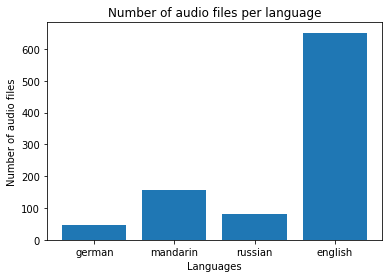

In [10]:
df_stats_in_sec = get_stats(lang_dict_seconds)
plot_num_files_per_language(df_stats_in_sec)

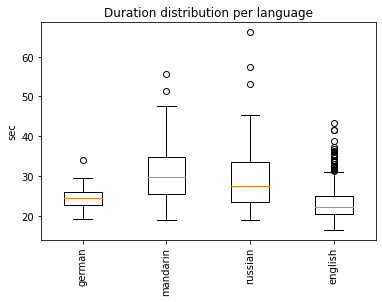

In [20]:
plot_boxplot_duration(lang_dict_seconds)

In [12]:
df_stats_in_sec

,german,mandarin,russian,english
count,45.000000,156.000000,81.000000,651.000000
mean,24.603744,30.816396,29.573240,23.041864
std,3.010577,6.798003,8.871543,3.894148
min,19.229161,18.924263,18.896735,16.460544
25%,22.824717,25.486338,23.447166,20.542404
50%,24.412426,29.745669,27.433288,22.291156
75%,26.038639,34.685181,33.418322,24.864853
max,34.014830,55.590023,66.142041,43.409887


Number of files per language is very varying - ranging from 45 audio clips for German to 651 for English. 
The audio file durations are also very different - from about 16 sec for English, up to 66 sec for Russian.

# Languages Set 2: 
## English, Russian, Arabic, French

In [13]:
L2_DATASET_PATH = "./data/lang_set_2"
lang_dict_frames_2, lang_dict_seconds_2 = get_lang_dicts(L2_DATASET_PATH)

IntProgress(value=0, max=687)

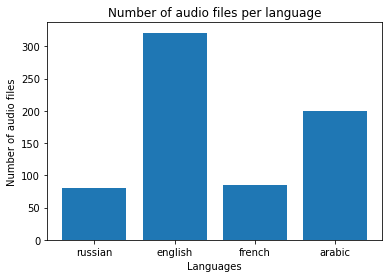

In [22]:
df_stats_in_sec_2 = get_stats(lang_dict_seconds_2)
plot_num_files_per_language(df_stats_in_sec_2)

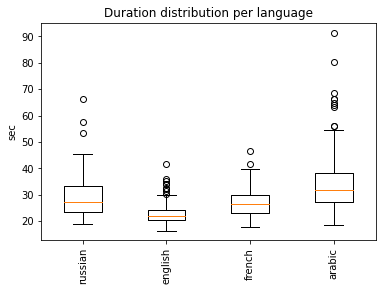

In [21]:
plot_boxplot_duration(lang_dict_seconds_2)

In [16]:
df_stats_in_sec_2

,russian,english,french,arabic
count,81.000000,321.000000,85.000000,200.000000
mean,29.573240,22.602061,27.429930,34.155488
std,8.871543,3.430254,5.769204,10.996224
min,18.896735,16.460544,17.774240,18.618866
25%,23.447166,20.286757,22.941315,27.185646
50%,27.433288,22.119864,26.643447,31.875102
75%,33.418322,24.244218,30.069841,38.288537
max,66.142041,41.670385,46.643084,91.325714


# Conclusion

EDA showed that:
1) the dataset is very imbalanced, some languages having far more audio tracks than others. <br>
2) the audio tracks have varying duration, in other words the signal length is different for each audio track.

But numpy doesn’t support ragged arrays, so we need to find a way to make audio tracks of the same size.


When working on this project, we faced the following **preprocessing dilemmas**:
    
1. Should we balance the dataset?
2. Should we filter by country as described in the project proposal (for Germany that results in having only 35 audio files)?
3. We need to make audio tracks of the same size:
    - should we limit the duration to the minimum duration based on the dataset? 
    - or do zero-padding for shorter audio tracks?
    - or do both: limit to some average duration and do zero-padding if shorter?
4. Should we chop audio tracks into segments? This would help to increase the dataset size and also solve the problem with #3 (having tracks of same size). But how to decide upon the correct size of segments?